# Dataset Generation

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

## Templates
we have 39 kinds of templates for 4 languages, but we only use 'de' and 'en' here for testing.

In [2]:
# templates
templates = pd.read_json("data/templates.json")
init_uttr_updated = pd.read_csv("data/InitUtterance_list_updated.csv")
templates_updated = templates.merge(init_uttr_updated, on='id')
templates_updated = templates_updated[['id', 'en']] #'fr', 'it', 'de',
templates_updated.head()

id  \
0       MyCloud.OpenArea.Init.Utterance   
1    Router.SwitchOnWiFi.Init.Utterance   
2     Tv.GenericExitToTv.Init.Utterance   
3   Router.SwitchOffWiFi.Init.Utterance   
4  Tv.RadioChannelChange.Init.Utterance   

                                                  en  
0  {'texts': [{'ttsText': 'show {MyCloudArea} on ...  
1  {'texts': [{'ttsText': 'activate the Wi-Fi'}, ...  
2  {'texts': [{'ttsText': 'back to TV'}, {'ttsTex...  
3  {'texts': [{'ttsText': 'can you please switch ...  
4  {'texts': [{'ttsText': 'can you turn on radio ...

In [3]:
templates_updated.describe()

TypeError: unhashable type: 'dict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'dict'


id  \
count                            39   
unique                           39   
top     Tv.Recording.Init.Utterance   
freq                              1   

                                                       en  
count                                                  39  
unique                                                 39  
top     {'texts': [{'ttsText': 'activate {SmartHomeSce...  
freq                                                    1

## Entities
65K entities of 33 different types are included.
1/3 of them are from German environment.

In [10]:
# entities
entities = pd.read_json("data/entities.json")
entities = entities[['value', 'type', 'language', 'normalizedValue', 'aliases']]
entities.head()

value                 type language normalizedValue aliases
0     Widnau  LocalsearchLocation       de          widnau      []
1     Zurigo  LocalsearchLocation       it          zurigo      []
2  Solothurn  LocalsearchLocation       de       solothurn      []
3    Muttenz  LocalsearchLocation       de         muttenz      []
4       Lyss  LocalsearchLocation       de            lyss      []

In [7]:
entities.describe()

value        type language normalizedValue aliases
count   65471       65471    65471           65471   65471
unique  51272          33        4           52082    3793
top      Golf  SeriesName       de            golf      []
freq       20       17913    22746              20   59649

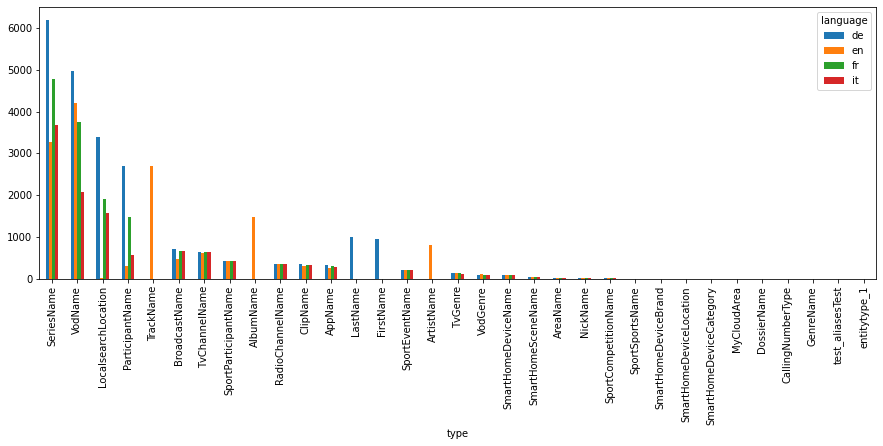

In [4]:
df = entities[['type', 'language']]
df = df.groupby(['type','language']).size().reset_index(name='count')
df2 = df.pivot(index='type', columns='language', values='count')
df2['sum'] = 0
df2 = df2.fillna(0)
for lang in ['de', 'en', 'fr', 'it',]:
    df2['sum'] += df2[lang]
# df.sort_values('count', ascending=False)
p = df2.sort_values('sum', ascending=False)[['de', 'en', 'fr', 'it']].plot(kind='bar', figsize=(15, 5))

## Entities_meta

In [3]:
# entities
entities_meta = pd.read_json("data/entities_meta.json").sort_index()
entities_meta.head()


value                 type language normalizedValue aliases
0     Widnau  LocalsearchLocation       de          widnau      []
1     Zurigo  LocalsearchLocation       it          zurigo      []
2  Solothurn  LocalsearchLocation       de       solothurn      []
3    Muttenz  LocalsearchLocation       de         muttenz      []
4       Lyss  LocalsearchLocation       de            lyss      []

In [7]:
df = entities_meta[['type', 'language']]
df = df.groupby(['type','language']).size().reset_index(name='count')
df2 = df.pivot(index='type', columns='language', values='count')
df2['sum'] = 0
df2 = df2.fillna(0)
for lang in ['de', 'en', 'fr', 'it',]:
    df2['sum'] += df2[lang]
# df.sort_values('count', ascending=False)
p = df2.sort_values('sum', ascending=False)[['de', 'en', 'fr', 'it']].plot(kind='bar', figsize=(15, 5))


### Find the representative
One entity usually has various name, thus, to improve speed, we need to find the representative ones that could retrieve all.
Considering the speaking speed and noise of ASR, we decide to:
1. Combine abbreviation as a upper case word (s r f, S R F -> SRF)
2. Keep the uppercase one if two words spell same (Schweiz, schweiz -> Schweiz)

In [5]:
# TODO: deal with case "a"
from generator.tools import filter_aliases
sample_aliases1 = [
    "TF 3",         # value
    "TF three",     # normalized
    "T F 3",        # alias
    "t f three",    # alias
    "t f 3"         # alias
    ]
filter_aliases(sample_aliases1,'en')

['TF 3']

## Read custom template
For time related templates:
* Localsearch.TemperatureInfo.Init.Utterance
* Localsearch.RainInfo.Init.Utterance
* Localsearch.WeatherInfo.Init.Utterance

exist problem that they use "TimeStamp" to represent both clock time (3 o'clock) and day time ("tomorrow", "Monday", etc.)
But their use cases are different. So we updated general "TimeStamp" -> "TimeStampDay" and "TimeStampTime" for DE and EN

In [4]:
# update template
df = pd.read_json("data/timestamp_de_noted.json")
templates_updated.update(df)

df = pd.read_json("data/timestamp_en_noted.json")
templates_updated.update(df)

## Generation

In [6]:
from tqdm import tqdm
from generator.module import Generator

gen = Generator(templates=templates_updated, entities=entities_meta, method='one')
gen.get_command(target_id='Localsearch.TemperatureInfo.Init.Utterance', target_lang='en', verbose=False)

[(['can',
   'you',
   'tell',
   'me',
   'how',
   'warm',
   'it',
   'will',
   'get',
   'on',
   '5.4'],
  ['can',
   'you',
   'tell',
   'me',
   'how',
   'warm',
   'it',
   'will',
   'get',
   'on',
   'fifth',
   'april'])]

In [7]:
from tqdm import tqdm
from generator.module import Generator

gen = Generator(templates=templates_updated, entities=entities_meta, method='one')
sample_size = 10000
f_source = open("data/commands_source_en_70k.txt", "a")
f_target = open("data/commands_target_en_70k.txt", "a")

for temp_id in ['Localsearch.TemperatureInfo.Init.Utterance' ,
                'Localsearch.RainInfo.Init.Utterance',
                'Localsearch.WeatherInfo.Init.Utterance',
                'Tv.TvSearch.Init.Utterance',
                'Tv.TvChannelChange.Init.Utterance',
                'Tv.RadioChannelChange.Init.Utterance',
                'SmartHome.SwitchOnDevice.Init.Utterance'
                ]:
    for _ in tqdm(range(sample_size)):
        command_en, label_en = gen.get_command(target_id=temp_id, target_lang='en', verbose=False)[0]
        f_source.write("{}\n".format(' '.join(command_en)))
        f_target.write("{}\n".format(' '.join(label_en)))
f_source.close()
f_target.close()



100%|██████████| 10000/10000 [07:49<00:00, 21.32it/s]


In [4]:
from generator.normalizer import Normalizer
f_source = open("data/nums_source_en_10k.txt", "a")
f_target = open("data/nums_target_en_10k.txt", "a")

for num in range(10000):
    num_str = str(num) 
    num_norm = Normalizer().normalize_text(num_str, 'en')
    f_source.write("{}\n".format(num_str))
    f_target.write("{}\n".format(num_norm))
f_source.close()
f_target.close()